In [1]:
import Pkg

Pkg.activate(@__DIR__)

  Activating project at `~/gits/DisjunctiveToQUBO.jl/notebooks`


In [2]:
using Revise
using JuMP
using ToQUBO                 #px/indicator
using DisjunctiveProgramming #master
using DisjunctiveToQUBO
using QUBOTools
using LinearAlgebra
using HiGHS
using DWave
using AmplNLWriter

In [3]:
const τ = 0.05
const μ = 7.0

7.0

In [4]:
using Couenne_jll
const Couenne_Optimizer = () -> AmplNLWriter.Optimizer(Couenne_jll.amplexe);

In [5]:
includet("circles.jl")

$$
\begin{array}{rll}
    \displaystyle \min_{\mathbf{x}, \mathbf{Y}} & x_1 - x_2 + y_1 + 5y_2 \\
    \textrm{s.t.} & Y_1 \veebar Y_2 \\[0.75em]
                  & \displaystyle%
                    \left[\begin{array}{c} Y_{1} \\ (x_{1} + 1)^2 + (x_2 + 1)^2 \leq 1 \end{array}\right]
                    \bigvee
                    \left[\begin{array}{c} Y_{2} \\ (x_{1} - 1)^2 + (x_2 - 1)^2 \leq 1 \end{array}\right] \\[1.75em]
                  & -2 \leq x_{i} \leq 2 & \forall i \\
                  & Y_{i} \iff y_{i} = 1 & \forall i \\
                  & Y_{i} \in \{\textrm{True}, \textrm{False}\} & \forall i \\
                  & y_{i} \in \{0, 1\} & \forall i \\[1em]
\end{array}
$$

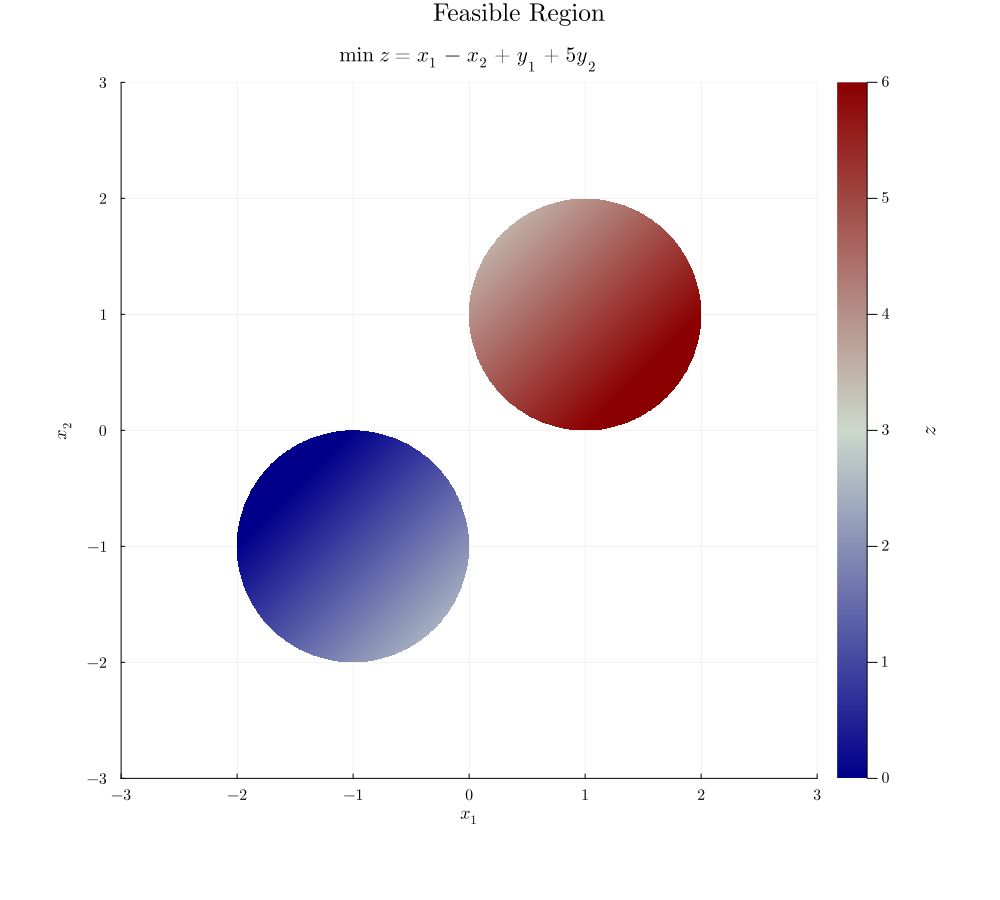

In [6]:
let plt = plot_circle_feasible()
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "circle-feasible.pdf"))

    plt
end

## Optimal Solution

In [7]:
x⃰, z⃰ = let model = solve_gdp_circles(Couenne_Optimizer; method=Hull()) do m
        
    end
    
    value.(model[:x]), objective_value(model)
end

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: 

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -0.4142136       21 0.063664
Couenne: new cutoff value -4.1421357651e-01 (0.115631 seconds)


NLP0014I             2         OPT -0.41421359       24 0.093655
Loaded instance "/tmp/jl_hoUNhw/model.nl"
Constraints:           13
Variables:              8 (2 integer)
Auxiliaries:           17 (0 integer)

Coin0506I Presolve 14 (-15) rows, 5 (-20) columns and 31 (-38) elements
Clp0006I 0  Obj -2.5 Primal inf 7.7849848 (7)
Clp0006I 10  Obj -0.48573827
Clp0000I Optimal - objective value -0.48573827
Clp0032I Optimal objective -0.4857382671 - 10 iterations time 0.002, Presolve 0.00
Clp0000I Optimal - objective value -0.48573827
Cbc0012I Integer solution of -0.41421359 found by Couenne Rounding NLP after 0 iterations and 0 nodes (0.00 seconds)
NLP Heuristic: NLP0014I             3         OPT -0.41421357        4 0.004024
no solution.
Clp0000I Optimal - objective value -0.48573827
Optimality Based BT: 8 improved bounds
Probing: 1 improved bounds
Cbc0031I 3 added rows had average density of 2
Cbc0013I At root node, 5 cuts changed objective from -0.48573827 to -0.4142201 in 6 passes
Cbc00

([-1.707106794672133, -0.29289320525796586], -0.4142135894141672)

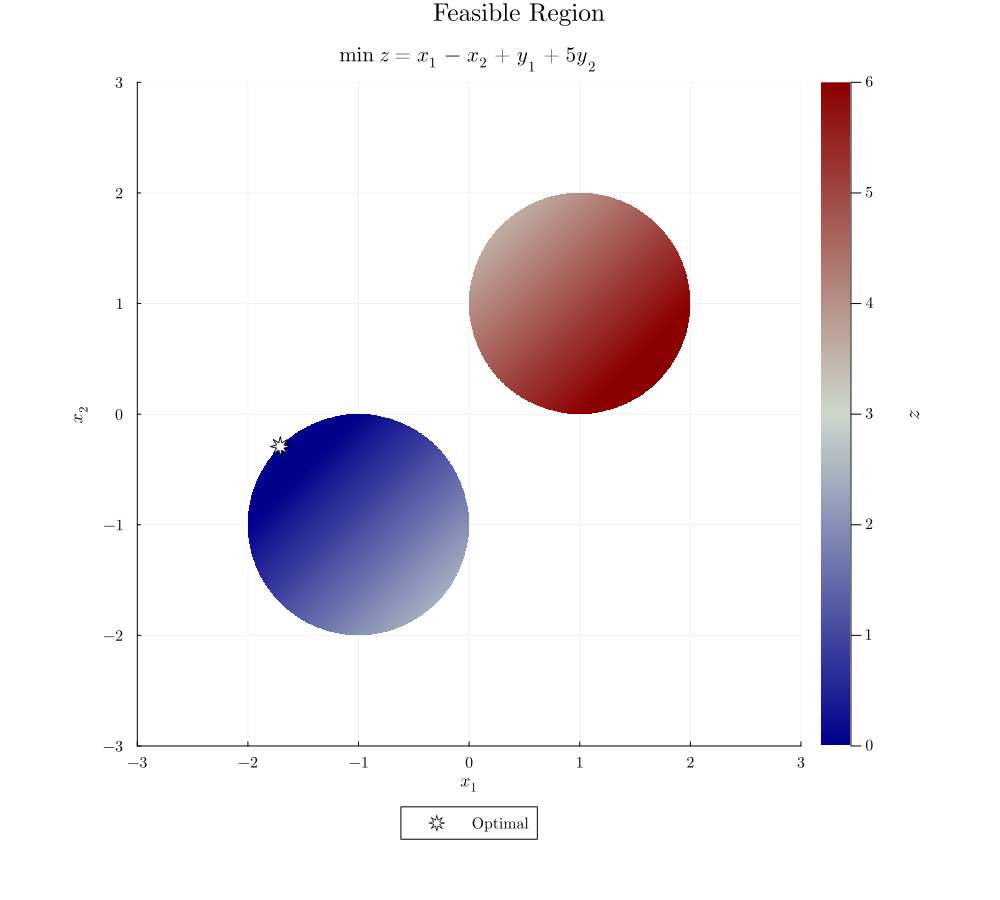

In [8]:
let plt = plot_circle_optimal(x⃰)
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "circle-optimal.pdf"))

    plt
end

## Big-$M$ Reformulation

In [9]:
M = 14.0

bigm_sa_model = solve_gdp_circles(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = BigM(M, false)
) do m
    set_attribute(m, "num_reads", 1_000)
    set_attribute(m, "num_sweeps", 4_000)

    set_attribute(m, ToQUBO.Attributes.Discretize(), false)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

bigm_qa_model = solve_gdp_circles(
    () -> ToQUBO.Optimizer(DWave.Optimizer),
    method = BigM(M, false)
) do m
    set_attribute(m, "num_reads", 1_000)
    set_attribute(m, "annealing_time", 200.0)
    set_attribute(m, "return_embedding", true)

    set_attribute(m, ToQUBO.Attributes.Discretize(), false)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end;

In [10]:
open(joinpath(@__DIR__, "data", "circles-bigm-sa.txt"), "w") do io
    println(io, compilation_summary(bigm_sa_model))
    println(io, sampling_summary(bigm_sa_model, z⃰ * (1 + τ)), μ) # 5% above optimal
    println(io, solution_summary(bigm_sa_model))
end

open(joinpath(@__DIR__, "data", "circles-bigm-qa.txt"), "w") do io
    println(io, compilation_summary(bigm_qa_model))
    println(io, sampling_summary(bigm_qa_model, z⃰ * (1 + τ)), μ) # 5% above optimal
    println(io, solution_summary(bigm_qa_model))
end;

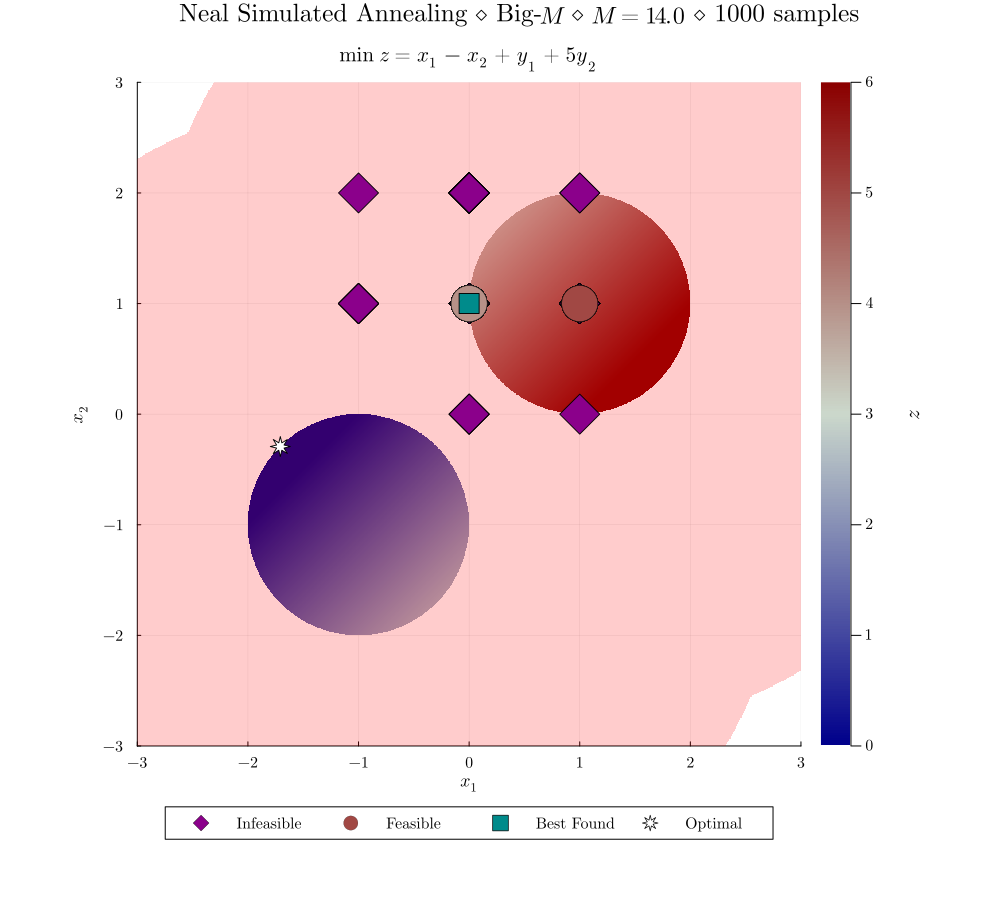

In [11]:
let plt = plot_circle_bigm(
        bigm_sa_model,
        x⃰,
        M;
        plot_title="Neal Simulated Annealing $(diamond) Big-\$M\$ $(diamond) \$M = $(M)\$ $(diamond) $(result_count(bigm_sa_model)) samples",
        feasible = <(μ),
    )
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "circle-bigm-sa.pdf"))

    plt
end

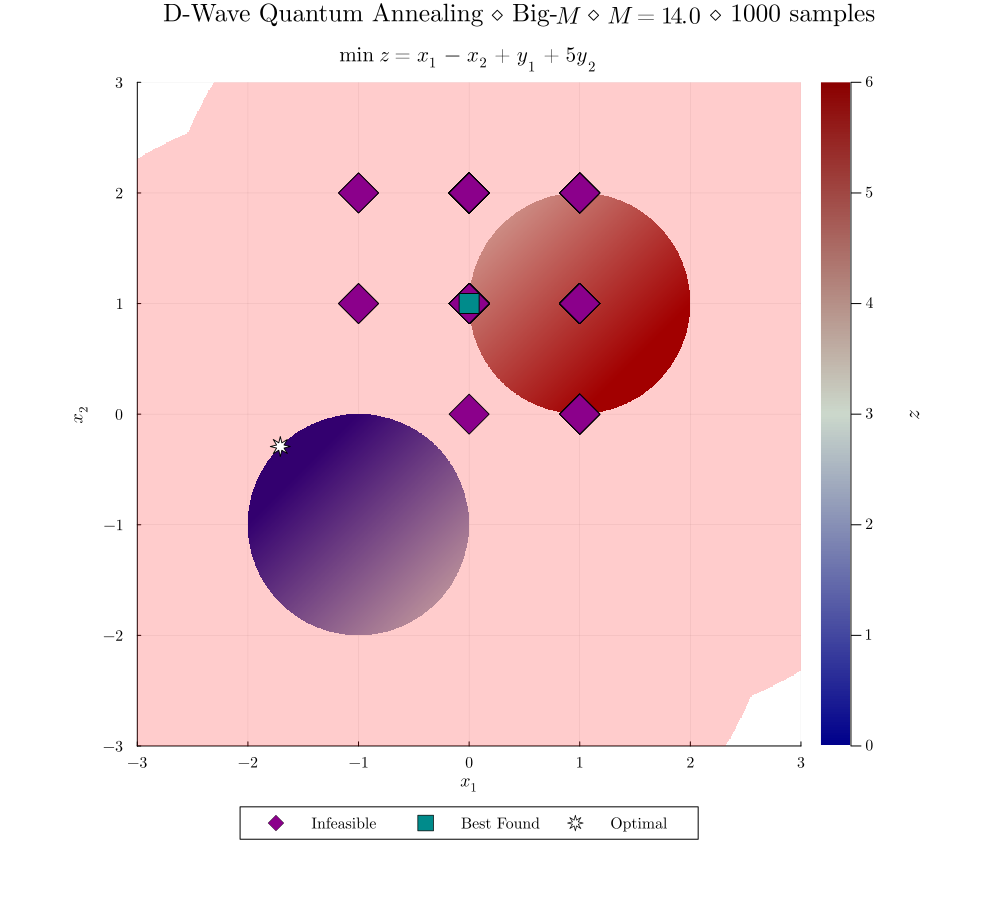

In [12]:
let plt = plot_circle_bigm(
        bigm_qa_model,
        x⃰,
        M;
        plot_title="D-Wave Quantum Annealing $(diamond) Big-\$M\$ $(diamond) \$M = $(M)\$ $(diamond) $(result_count(bigm_qa_model)) samples",
        feasible = <(μ),
    )
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "circle-bigm-qa.pdf"))

    plt
end

## Hull Reformulation

In [13]:
# hull_sa_model = solve_gdp_circles(
#     () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
#     method = Hull()
# ) do m
#     set_attribute(m, "num_reads", 1_000)
#     set_attribute(m, "num_sweeps", 4_000)

#     set_attribute(m, ToQUBO.Attributes.Discretize(), false)

#     set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
#     set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
# end

# hull_qa_model = solve_gdp_circles(
#     () -> ToQUBO.Optimizer(DWave.Optimizer),
#     method = Hull()
# ) do m
#     set_attribute(m, "num_reads", 1_000)
#     set_attribute(m, "annealing_time", 200.0)
#     set_attribute(m, "return_embedding", true)

#     set_attribute(m, ToQUBO.Attributes.Discretize(), false)

#     set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
#     set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
# end;

## Indicator Refoormulation

In [14]:
ind_sa_model = solve_gdp_circles(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = Indicator()
) do m
    set_attribute(m, "num_reads", 1_000)
    set_attribute(m, "num_sweeps", 4_000)

    set_attribute(m, ToQUBO.Attributes.Discretize(), false)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

ind_qa_model = solve_gdp_circles(
    () -> ToQUBO.Optimizer(DWave.Optimizer),
    method = Indicator()
) do m
    set_attribute(m, "num_reads", 1_000)
    set_attribute(m, "annealing_time", 200.0)
    set_attribute(m, "return_embedding", true)

    set_attribute(m, ToQUBO.Attributes.Discretize(), false)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end;

In [15]:
open(joinpath(@__DIR__, "data", "circles-ind-sa.txt"), "w") do io
    println(io, compilation_summary(ind_sa_model))
    println(io, sampling_summary(ind_sa_model, z⃰ * (1 + τ)), μ) # 5% above optimal
    println(io, solution_summary(ind_sa_model))
end

open(joinpath(@__DIR__, "data", "circles-ind-qa.txt"), "w") do io
    println(io, compilation_summary(ind_qa_model))
    println(io, sampling_summary(ind_qa_model, z⃰ * (1 + τ)), μ) # 5% above optimal
    println(io, solution_summary(ind_qa_model))
end;

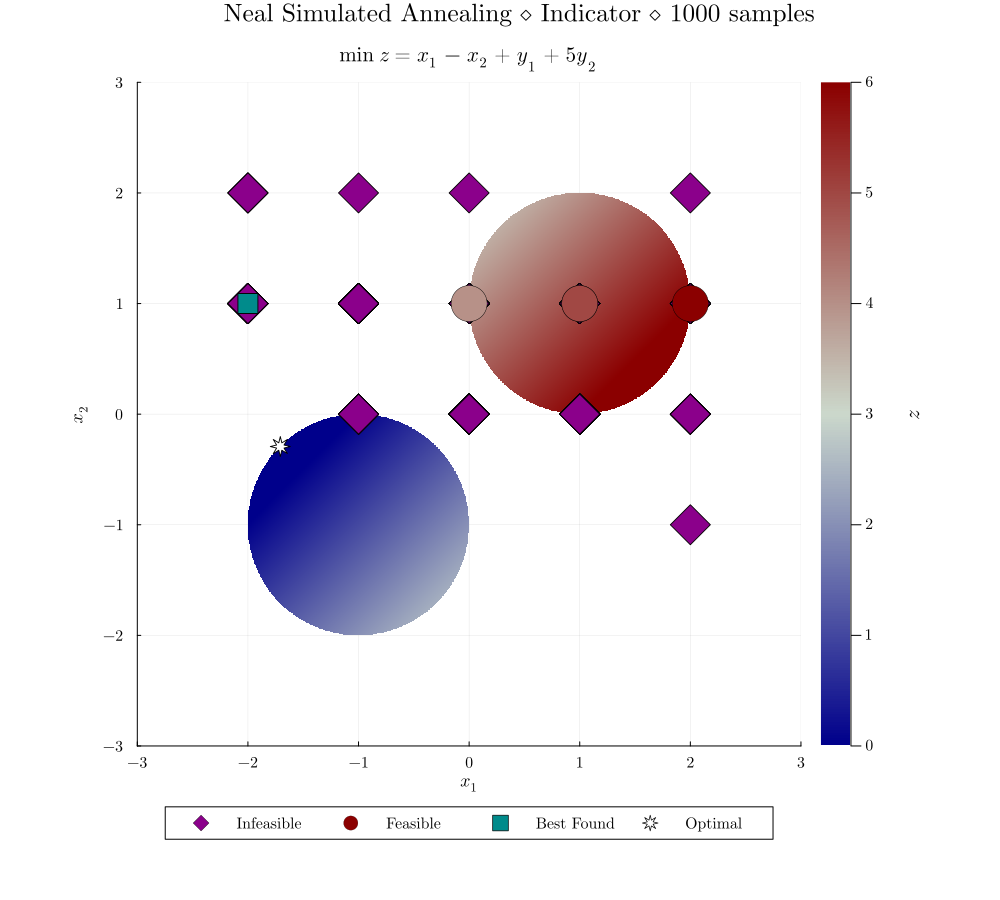

In [16]:
let plt = plot_circle_indicator(
        ind_sa_model,
        x⃰;
        plot_title="Neal Simulated Annealing $(diamond) Indicator $(diamond) $(result_count(ind_sa_model)) samples",
        feasible = <(μ),
    )
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "circle-ind-sa.pdf"))

    plt
end

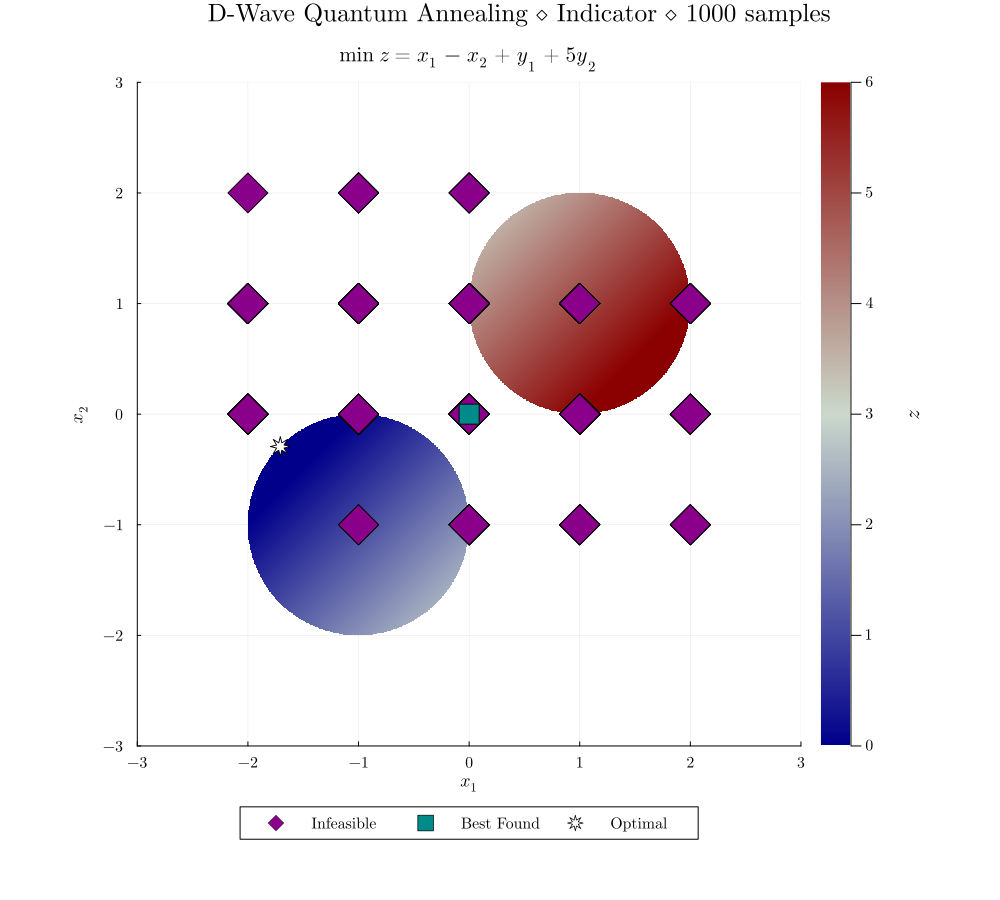

In [17]:
let plt = plot_circle_indicator(
        ind_qa_model,
        x⃰;
        plot_title="D-Wave Quantum Annealing $(diamond) Indicator $(diamond) $(result_count(ind_qa_model)) samples",
        feasible = <(μ),
    )
    Plots.savefig(plt, joinpath(@__DIR__, "plots", "circle-ind-qa.pdf"))

    plt
end

## Summary

In [18]:
table_summary(
    [
        raw"Big-$M$" => (bigm_sa_model, bigm_qa_model),
        # raw"Hull" => (hull_sa_model, hull_qa_model),
        raw"Indicator" => (ind_sa_model, ind_qa_model),
    ],
    z⃰ * (1 + τ), # 5% above optimal,
    μ,           # Feasibility threshhold
) |> println

\begin{tabular}{|l|ccccccc|}
\hline
Reformulation Method & $\log_{10}\Delta$ & $n_{\textrm{vars}}$ & $\textrm{TTT}_{\textrm{SA}}$ & $\textrm{TTF}_{\textrm{SA}}$ & $n_{\textrm{qubits}}$ & $\textrm{TTT}_{\textrm{QA}}$ & $\textrm{TTF}_{\textrm{QA}}$ \\
\hline
  Big-$M$   & 3.82 & 309 & $\infty$            & $\gtrapprox 10^{3}$ & 665 & $\infty$ & $\infty$ \\
  Indicator & 3.84 & 312 & $\gtrapprox 10^{4}$ & $\gtrapprox 10^{4}$ & 586 & $\infty$ & $\infty$ \\
\hline
\end{tabular}

